### 訓練 深度學習 模型

* 獲取語音資料 ryGsc_sil1.npz
* 設計深度學習模型 NNmodel
* 運用語音資料反覆訓練出 模型中所有的參數 ==> ry_best_model1.hdf5


In [1]:
# In[]
import numpy as np
import time

fn= 'ryGsc_sil1.npz'
fnModel= 'ry_best_model1.hdf5'

print(".... z= np.load({}) will train into {}".format(fn, fnModel))

t0= time.time()

z= np.load(fn)

x_test=     z['x_test']     
y_test=     z['y_test']     
x_testREAL= z['x_testREAL'] 
y_testREAL= z['y_testREAL'] 
x_train=    z['x_train']    
y_train=    z['y_train']    
x_val=      z['x_val']      
y_val=      z['y_val']

x_testREAL0= x_testREAL[y_testREAL==0]
y_testREAL0= y_testREAL[y_testREAL==0]
    
x_testREAL1= x_testREAL[y_testREAL!=0]
y_testREAL1= y_testREAL[y_testREAL!=0]

#t0= time.time()
dt= time.time()- t0
print('... z= np.load() ... dt(sec)= {:.3f}'.format(dt))

## z= np.load() ... dt(sec)= 75.36865901947021


.... z= np.load(ryGsc_sil1.npz) will train into ry_best_model1.hdf5
... z= np.load() ... dt(sec)= 41.688


In [3]:
x_train.shape, x_val.shape, x_test.shape, x_testREAL.shape

((85245, 16000), (9981, 16000), (11005, 16000), (4890, 16000))

In [4]:
y_train.shape, y_val.shape, y_test.shape, y_testREAL.shape

((85245,), (9981,), (11005,), (4890,))

Populating the interactive namespace from numpy and matplotlib


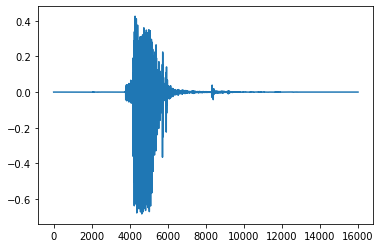

In [8]:
%pylab inline
import pylab as pl
import sounddevice as sd
x= x_train[0]
pl.plot(x)
sd.play(x, samplerate=16000)

In [9]:
# doing the Feature Extraction, mel-scale spectrogram

import tensorflow as tf

def ryFeature(x, 
           sample_rate= 16000, 
           
           frame_length= 1024,
           frame_step=    128,  # frame_length//2
           
           num_mel_bins=     128,
           lower_edge_hertz= 20,     # 0
           upper_edge_hertz= 16000/2, # sample_rate/2   
           
           mfcc_dim= 13
           ):
    
    stfts= tf.signal.stft(x, 
                          frame_length, #=  256, #1024, 
                          frame_step, #=    128,
                          #fft_length= 1024
                          pad_end=True
                          )
    
    spectrograms=     tf.abs(stfts)
    log_spectrograms= tf.math.log(spectrograms + 1e-10)
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins= stfts.shape[-1]  #.value
    
    linear_to_mel_weight_matrix= tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, 
          num_spectrogram_bins, 
          sample_rate, 
          lower_edge_hertz,
          upper_edge_hertz)
    
    mel_spectrograms= tf.tensordot(
          spectrograms, 
          linear_to_mel_weight_matrix, 1)
    
    mel_spectrograms.set_shape(
          spectrograms.shape[:-1].concatenate(
              linear_to_mel_weight_matrix.shape[-1:]))
    
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms= tf.math.log(mel_spectrograms + 1e-10)
    
    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs= tf.signal.mfccs_from_log_mel_spectrograms(
          log_mel_spectrograms)[..., :mfcc_dim]
    
    feature= {'mfcc':               mfccs, 
              'log_mel_spectrogram':log_mel_spectrograms, 
              'log_spectrogram':    log_spectrograms, 
              'spectrogram':        spectrograms}
    
    return  feature


_='''
batch_size= 1000  # 預防 gpu memory 不夠， 分批作業 
x= x_train[0:batch_size].astype(np.float32)
X= ryFeature(x)['log_mel_spectrogram']
X= X.numpy()
'''


"\nbatch_size= 1000  # 預防 gpu memory 不夠， 分批作業 \nx= x_train[0:batch_size].astype(np.float32)\nX= ryFeature(x)['log_mel_spectrogram']\nX= X.numpy()\n"

In [10]:
import time

import tensorflow as tf


def get_all_fearure(all_x, batch_size= 1000):
    t0= time.time()
    
    x= all_x.astype(np.float32)
    
    #batch_size= 1000  # 預防 gpu memory 不夠， 分批作業 
    
    i=0
    XL=[]
    while i < x.shape[0]:
        
        if i+batch_size<=x.shape[0]:
            xx= x[i:i+batch_size]
        else:
            xx= x[i:]
        
        XX= ryFeature(xx)
        X= XX['log_mel_spectrogram'] 
        #'log_spectrogram'] #'mfcc'] #'log_mel_spectrogram']
        
        X= X.numpy().astype(np.float32)
        
        i  += batch_size
        XL += [X]
    
    XL= np.concatenate(XL)
    print('XL.shape={}'.format(XL.shape))
    
    dt= time.time()-t0
    print('tf.signal.stft, 執行時間 dt= {}'.format(dt))
    
    '''
    XL.shape=(64721, 125, 129) # nTime= 16000/128, nFreq=256/2+1
    tf.signal.stft, dt= 8.066392660140991
    '''
    return XL


In [11]:
# In[]
print('.... get_all_fearure() .... ')

t0= time.time()

X_testREAL= get_all_fearure(x_testREAL)
X_test=     get_all_fearure(x_test)
X_val=      get_all_fearure(x_val)
X_train=    get_all_fearure(x_train)

#t0= time.time()
dt= time.time()- t0
print('... get_all_fearure() ... dt(sec)= {:.3f}'.format(dt))

### get_all_fearure() ... dt(sec)= 36.128026723861694
### get_all_fearure() ... dt(sec)= 52.950
# ... get_all_fearure() ... dt(sec)= 39.218

.... get_all_fearure() .... 
XL.shape=(4890, 125, 128)
tf.signal.stft, 執行時間 dt= 5.168047666549683
XL.shape=(11005, 125, 128)
tf.signal.stft, 執行時間 dt= 1.7962088584899902
XL.shape=(9981, 125, 128)
tf.signal.stft, 執行時間 dt= 1.6092772483825684
XL.shape=(85245, 125, 128)
tf.signal.stft, 執行時間 dt= 30.0707905292511
... get_all_fearure() ... dt(sec)= 39.218


In [13]:
# In[]
def normalize(x, axis= None):   
    if axis== None:
        x= (x-x.mean())/x.std()
    else:
        x= (x-x.mean(axis= axis))/x.std(axis= axis)
    
    return x

# In[]
print('.... normalize() ....')
nTime, nFreq= X_train[0].shape

X_train= X_train.reshape(-1, nTime, nFreq, 1).astype('float32') 
X_val=   X_val.reshape(-1, nTime, nFreq, 1).astype('float32') 
X_test=  X_test.reshape( -1, nTime, nFreq, 1).astype('float32') 
X_testREAL=  X_testREAL.reshape( -1, nTime, nFreq, 1).astype('float32') 

#'''  好像重複做了？！
X_train=     normalize(X_train)#, axis=0)  # normalized for the all set, many utterence
X_val=       normalize(X_val)#, axis=0)
X_test=      normalize(X_test)#, axis=0)
X_testREAL=  normalize(X_testREAL)#, axis=0)

.... normalize() ....


In [14]:
import tensorflow as tf

tf.keras.backend.clear_session()  
# For easy reset of notebook state.

from tensorflow              import keras
from tensorflow.keras        import layers, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling1D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 設計深度學習模型 CNN

In [15]:
nCategs= len(set(y_train)) #36 #c_train.size #36


x= Input(shape= (nTime, nFreq, 1))

h= x


#'''
h= Conv2D(8,   (16,16), activation='relu', padding='same')(h)
h= MaxPooling2D((4,4), padding='same')(h)
h= Dropout(0.2)(h)

h= Conv2D(16,   (8,8), activation='relu', padding='same')(h)
h= MaxPooling2D((4,4), padding='same')(h)
h= Dropout(0.2)(h)

h= Flatten()(h)

h= Dense(256,  activation='relu')(h)
h= Dropout(0.2)(h)


h= Dense(nCategs,  activation='softmax')(h)

y= h

m= Model(inputs=  x, 
         outputs= y)

m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 128, 8)       2056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        8208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 16)          0     

In [17]:
#keras.utils.plot_model(m, 'm.png', show_shapes=True)

![m.png](./m.png)

In [18]:
m.compile(  
        loss=    'sparse_categorical_crossentropy',
        metrics= ['accuracy'])


es= EarlyStopping(
        monitor=   'val_loss', 
        min_delta= 1e-10,
        patience=  10, 
        mode=      'min', 
        verbose=   1) 



mc= ModelCheckpoint(fnModel, 
        monitor=    'val_accuracy', 
        verbose=    1, 
        save_best_only= True, 
        mode=      'max')

### 開始訓練囉....

In [ ]:
t0= time.time()

h= m.fit(X_train, y_train,
         
        batch_size=500, #1000, # 1000
        epochs=    100,
        
        callbacks=[es, mc],
        
        #validation_split= 0.1
        validation_data= (X_val, y_val)
        )


#t0= time.time()
dt= time.time()- t0
print('... h= m.fit() ... dt(sec)= {}'.format(dt))

_= '''
Epoch 00029: val_accuracy did not improve from 0.91544
85245/85245 [==============================] - 15s 179us/sample - loss: 0.2870 - accuracy: 0.9101 - val_loss: 0.3144 - val_accuracy: 0.9154
Epoch 00029: early stopping
... h= m.fit() ... dt(sec)= 447.87419843673706
'''

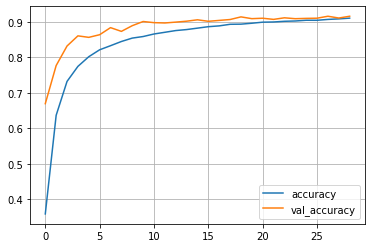

In [20]:
# In[]
import numpy as np
from matplotlib import pyplot as pl
v0= h.history['accuracy']
v1= h.history['val_accuracy']
pl.plot(v0, label='accuracy')
pl.plot(v1, label='val_accuracy')
pl.legend()
pl.grid('on')
pl.show()

### 用 測試資料集合 X_test 來 評估 NN模型的正確率 (accuracy)

In [21]:
m.evaluate(X_test,      y_test,      verbose=2)

11005/1 - 1s - loss: 0.4900 - accuracy: 0.9067


[0.34178569991120444, 0.9066788]

### 再用 另一組 測試資料 testREAL 來測試

但這組資料有一些標錯的地方，我們把它隔離出來。



In [22]:
#
# testREAL 裡面，有 408 個  _silence_ 標為 0
# 還有 408 個 各式語音 放在 _unknown_ 也被標示為 0 !!!
#

X_testREAL00= X_testREAL[y_testREAL==0][0:408]
y_testREAL00= y_testREAL[y_testREAL==0][0:408]
    
X_testREAL01= X_testREAL[y_testREAL==0][408:]
y_testREAL01= y_testREAL[y_testREAL==0][408:]

X_testREAL1= X_testREAL[y_testREAL!=0]
y_testREAL1= y_testREAL[y_testREAL!=0]
  

m.evaluate(X_testREAL1, y_testREAL1, verbose=2)   # 這個才算正常的 35 字 中的 大約 10 字
m.evaluate(X_testREAL00, y_testREAL00, verbose=2) # 這個還可看看，_silence_ 的正確率
m.evaluate(X_testREAL01, y_testREAL01, verbose=2) # 這個應該全錯，這叫做 標記錯誤，這小部分要重新安排！！！


4074/1 - 1s - loss: 0.3143 - accuracy: 0.9065
408/1 - 0s - loss: 0.4422 - accuracy: 0.9461
408/1 - 0s - loss: 57.2946 - accuracy: 0.0025


[53.93811715817919, 0.0024509805]

In [23]:
### 告一段落

In [24]:

print(' ~~~ simulation session ended ~~~')

 ~~~ simulation session ended ~~~


In [25]:
### 底下實作一個 用你真實的語音實際測試的範例，

# In[]
import numpy as np
from tensorflow.keras.models import load_model
import sounddevice as sd

import audioUtils


labels= np.array([
        '_silence_', 
        'nine', 
        'yes', 
        'no', 
        'up', 
        'down', 
        'left', 
        'right',
        'on', 
        'off', 
        'stop', 
        'go', 
        'zero', 
        'one', 
        'two', 
        'three', 
        'four',
        'five', 
        'six', 
        'seven', 
        'eight', 
        'backward', 
        'bed', 
        'bird', 
        'cat',
        'dog', 
        'follow', 
        'forward', 
        'happy', 
        'house', 
        'learn', 
        'marvin',
        'sheila', 
        'tree', 
        'visual', 
        'wow'], 
        dtype='<U11')

In [28]:
model= load_model(fnModel)

'''
classList= ['_silence_', 'nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']
'''

classList= labels.tolist()

def predict(x):#, fs=16000):
    prob=  model.predict(x)#.reshape(1,fs,1))
    index= np.argmax(prob[0])
    y= labels[index]
    return y

def recWav(x, featureOut= False):
    x= x.flatten()    

    X= ryFeature(x)['log_mel_spectrogram']
    
    X= X.numpy().astype(np.float32)
    
    X= normalize(X)  # normalized for only one utterence x

    Xin= X.reshape(1,X.shape[0],X.shape[1], 1)
    y= predict(Xin)
    
    if featureOut == True:
        return y, X
    else:
        return y

In [29]:

print('''##########
a Real-time Test..., 
press 【Enter】and speak out within 1 sec      
the words are in the list of 35 words: 

###################
{}
###################

PS: (you cannot say '_silence_', 
it just for "silence" 
or "no sound" 
or "background noise") 
'''.format(classList))


    
T=  1     # Duration of recording
fs= 16000  # Sample rate

xL= []
for i in range(100):
    
    aKey= input('{}\n{}\n'.format(
                'press "q" to quit', 
                'or another key to record 1 sec speech...'))
    if aKey=='q':
        print('~~~the end~~~')
        break
    
    x= sd.rec(int(T*fs), 
            samplerate= fs, 
            channels= 1, 
            dtype='float32')
        
    sd.wait()  # Wait until recording is finished
    
    y= recWav(x)
    
    print('y= 【{}】'.format(y))

    xL += [x]

##########
a Real-time Test..., 
press 【Enter】and speak out within 1 sec      
the words are in the list of 35 words: 

###################
['_silence_', 'nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'backward', 'bed', 'bird', 'cat', 'dog', 'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree', 'visual', 'wow']
###################

PS: (you cannot say '_silence_', 
it just for "silence" 
or "no sound" 
or "background noise") 

press "q" to quit
or another key to record 1 sec speech...

y= 【yes】
press "q" to quit
or another key to record 1 sec speech...

y= 【no】
press "q" to quit
or another key to record 1 sec speech...

y= 【up】
press "q" to quit
or another key to record 1 sec speech...

y= 【happy】
press "q" to quit
or another key to record 1 sec speech...

y= 【house】
press "q" to quit
or another key to record 1 sec speech...
q
~~~the end~~~
